In [1]:
from socceraction.data.wyscout import PublicWyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions as convert_to_actions_wyscout
from socceraction.spadl.statsbomb import convert_to_actions as convert_to_actions_statsbomb
from socceraction.data.opta import OptaLoader
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.spadl.config import actiontypes, bodyparts
import socceraction.spadl as spadl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, brier_score_loss, log_loss, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
import math
import pickle
import os
from name_matching.name_matcher import NameMatcher
from rapidfuzz import fuzz
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import r_regression, SelectKBest, chi2, mutual_info_classif, SequentialFeatureSelector, RFECV, SelectFromModel
from scipy.stats import pearsonr, chisquare
from mrmr import mrmr_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVR, SVC
from sklearn.linear_model import Lasso, LogisticRegression

In [2]:
# IMPORTANT CONSTANTS AND MAPS
MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR = {
    "xpass" : {
        "model_directory" : "data/model_xpass/",
        "csv_output_filename" : "xpass_player_skill_probs_dataset.csv",
        "type_ids_spadl" : [0,1]
    },
    "xgoal" : {
        "model_directory" : "data/model_xgoal/",
        "csv_output_filename" : "xgoal_player_skill_probs_dataset.csv",
        "type_ids_spadl" : [11, 12, 13]
    },
    "xdribble" : {
        "model_directory" : "data/model_xdribble/",
        "csv_output_filename" : "xdribble_player_skill_probs_dataset.csv",
        "type_ids_spadl" : [7, 21]
    }
}
DIRECTORY_STATSBOMB_NON_360_CSV_DATAS = "data/statsbomb_event_non_360_data"
DIRECTORY_FINAL_PLAYERS_CSV_DATAS = "data/players_skill_dataset/final_players_skill_dataset.csv"

In [3]:
api_statsbomb = StatsBombLoader(root="data/statsbomb", getter="local")

In [4]:
def convert_events_df_to_spadl_statsbomb(events_df, home_team_id):
    spadl_events_df = convert_to_actions_statsbomb(events_df, home_team_id)
    spadl_events_df['time_seconds'] = spadl_events_df['time_seconds'].astype('float64')
    spadl_events_df['timestamp'] = pd.to_datetime(spadl_events_df['time_seconds'], unit='s')
    return spadl_events_df

In [5]:
def collect_all_raw_statsbomb_non_360_spadl():
    api = api_statsbomb
    list_competitions_ids = []
    list_game_ids = []

    competitions_df = api.competitions()
    for _, row in competitions_df.iterrows():
        if row['competition_gender'] == 'male':
                list_competitions_ids.append((row['competition_id'], row['season_id']))
        
    for competition_id, season_id in list_competitions_ids:
        games_df = api.games(competition_id, season_id)
        for _, row in games_df.iterrows():
            list_game_ids.append((row['game_id'], row['home_team_id'], row['away_team_id']))
            
    for game_id, home_team_id, away_team_id in list_game_ids:
        this_game_events_df = api.events(game_id)
        this_game_events_spadl_df = convert_events_df_to_spadl_statsbomb(this_game_events_df, home_team_id)
        # Export to external csv iteratively
        this_game_events_spadl_df.to_csv(f'data/statsbomb_event_non_360_data/{game_id}_{home_team_id}_{away_team_id}_statsbomb_event_non_360_data.csv')         

In [6]:
# Comment it if statsbomb event 360 data already collected
# collect_all_raw_statsbomb_non_360_spadl()

In [7]:
def load_and_concat_statsbomb_non_360_df_from_csv():
    list_pass_event_df = []
    for filename in os.listdir(DIRECTORY_STATSBOMB_NON_360_CSV_DATAS):
        f = os.path.join(DIRECTORY_STATSBOMB_NON_360_CSV_DATAS, filename)
        if os.path.isfile(f):
            pass_event_df = pd.read_csv(f)
            list_pass_event_df.append(pass_event_df)
    return pd.concat(list_pass_event_df)

In [8]:
big_statsbomb_non_360_events_df = load_and_concat_statsbomb_non_360_df_from_csv()
big_statsbomb_non_360_events_df.head()

,Unnamed: 0,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,timestamp
0,0,15946,549567bd-36de-4ac8-b8dc-6b5d3f1e4be8,1,0.0,206,6581.0,52.058824,33.655696,76.058824,23.240506,0,1,4,0,1970-01-01 00:00:00.000
1,1,15946,44679971-4477-441a-947b-eca1d7786aaf,1,2.0,206,6855.0,76.058824,23.240506,73.411765,22.637975,21,1,0,1,1970-01-01 00:00:02.000
2,2,15946,4e4e4cad-9897-43ec-842d-585a4077f6ce,1,3.0,206,6855.0,73.411765,22.637975,29.558824,63.007595,0,0,5,2,1970-01-01 00:00:03.000
3,3,15946,be27cc25-92b5-4696-b43c-aad957a6119a,1,7.0,217,5203.0,28.764706,63.782278,30.088235,53.108861,0,1,0,3,1970-01-01 00:00:07.000
4,4,15946,b33c0b7f-7456-4efe-b43c-5fd7cbd14689,1,8.0,217,5470.0,30.088235,53.108861,31.058824,64.298734,0,1,1,4,1970-01-01 00:00:08.000


In [9]:
final_player_skills_dataset = pd.read_csv(DIRECTORY_FINAL_PLAYERS_CSV_DATAS)
final_player_skills_dataset.dropna(subset="player_id", inplace=True)
final_player_skills_dataset.head()

,Unnamed: 0.1,level_0,dex,index,Unnamed: 0,game_id,team_id,player_id,player_name,nickname,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
1,1,0,0,0.0,0.0,15946.0,217.0,3501.0,Philippe Coutinho Correia,Philippe Coutinho,...,70+3,69+3,69+3,69+3,70+3,66+3,58+3,58+3,58+3,66+3
2,2,0,0,1.0,1.0,15946.0,217.0,5203.0,Sergio Busquets i Burgos,Sergio Busquets,...,79+3,86+3,86+3,86+3,79+3,78+3,82+3,82+3,82+3,78+3
3,3,0,0,2.0,2.0,15946.0,217.0,5211.0,Jordi Alba Ramos,Jordi Alba,...,85+3,80+3,80+3,80+3,85+3,84+3,78+3,78+3,78+3,84+3
4,4,0,0,3.0,3.0,15946.0,217.0,5213.0,Gerard Piqué Bernabéu,Gerard Piqué,...,76+3,82+3,82+3,82+3,76+3,78+3,84+3,84+3,84+3,78+3
5,5,0,0,4.0,4.0,15946.0,217.0,5246.0,Luis Alberto Suárez Díaz,Luis Suárez,...,69+5,68+5,68+5,68+5,69+5,66+5,63+5,63+5,63+5,66+5


In [10]:
def count_total_success_action(row, statsbomb_event_non_360_df, list_type_ids, count_total):
    event_data_for_this_player_and_type = statsbomb_event_non_360_df[ \
        (statsbomb_event_non_360_df['player_id'] == row['player_id']) & \
        (statsbomb_event_non_360_df['type_id'].isin(list_type_ids))
    ]
    value_counts_success_df = event_data_for_this_player_and_type['result_id'].value_counts()
    total_success_action = 0
    total_action = 0
    for value, counter in value_counts_success_df.items():
        if (value == 1):
            total_success_action += counter
        total_action += counter
    return total_success_action if not count_total else total_action

def construct_player_skills_probabilities_dataset(statsbomb_event_non_360_df, final_player_skill_df):
    for key in list(MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR.keys()):
        list_type_ids = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR[key]["type_ids_spadl"]
        directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR[key]["model_directory"]
        output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR[key]["csv_output_filename"]

        modified_final_player_skills_df = final_player_skill_df.copy()
        modified_final_player_skills_df['statistic_total_success_action'] = modified_final_player_skills_df.apply(lambda x : count_total_success_action(x, statsbomb_event_non_360_df, list_type_ids, False), axis=1)
        modified_final_player_skills_df['statistic_total_action'] = modified_final_player_skills_df.apply(lambda x : count_total_success_action(x, statsbomb_event_non_360_df, list_type_ids, True), axis=1)
        modified_final_player_skills_df['statistic_success_action_probs'] = modified_final_player_skills_df['statistic_total_success_action'] / modified_final_player_skills_df['statistic_total_action']

        modified_final_player_skills_df = modified_final_player_skills_df[modified_final_player_skills_df['statistic_total_action'] != 0]
        modified_final_player_skills_df.to_csv(directory_model + output_csv_filename)

In [11]:
# Comment it out if player skill probabilities dataset already constructed
# construct_player_skills_probabilities_dataset(big_statsbomb_non_360_events_df, final_player_skills_dataset)

In [12]:
# Add additional computed field into xpass df (Comment it if already computed !!)
# directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["model_directory"]
# output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["csv_output_filename"]
# xpass_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
# total_success_passes_all_players = xpass_player_probs_df['statistic_total_success_action'].sum()
# xpass_player_probs_df['statistic_success_action_among_players'] = xpass_player_probs_df['statistic_total_success_action'] / total_success_passes_all_players
# xpass_player_probs_df['statistic_success_total'] = xpass_player_probs_df['statistic_success_action_among_players'] * xpass_player_probs_df["statistic_success_action_probs"]
# xpass_player_probs_df.to_csv(directory_model + output_csv_filename)

In [13]:
# Add additional computed field into xgoal df (Comment it if already computed !!)
# directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xgoal"]["model_directory"]
# output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xgoal"]["csv_output_filename"]
# xgoal_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
# total_success_shots_all_players = xgoal_player_probs_df['statistic_total_success_action'].sum()
# xgoal_player_probs_df['statistic_success_action_among_players'] = xgoal_player_probs_df['statistic_total_success_action'] / total_success_shots_all_players
# xgoal_player_probs_df['statistic_success_total'] = xgoal_player_probs_df['statistic_success_action_among_players'] * xgoal_player_probs_df["statistic_success_action_probs"]
# xgoal_player_probs_df.to_csv(directory_model + output_csv_filename)

In [14]:
# Add additional computed field into xdribble df (Comment it if already computed !!)
# directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xdribble"]["model_directory"]
# output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xdribble"]["csv_output_filename"]
# xdribble_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
# total_success_dribble_all_players = xdribble_player_probs_df['statistic_total_success_action'].sum()
# xdribble_player_probs_df['statistic_success_action_among_players'] = xdribble_player_probs_df['statistic_total_success_action'] / total_success_dribble_all_players
# xdribble_player_probs_df['statistic_success_total'] = xdribble_player_probs_df['statistic_success_action_among_players'] * xdribble_player_probs_df["statistic_success_action_probs"]
# xdribble_player_probs_df.to_csv(directory_model + output_csv_filename)

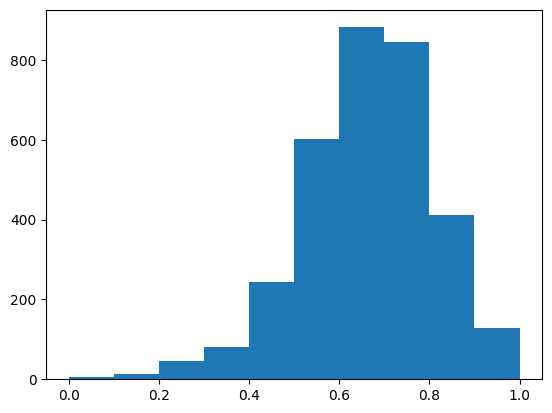

In [57]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Inspect Xpass Probabilites Player sorted from the highest 
directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["model_directory"]
output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["csv_output_filename"]
xpass_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
xpass_player_probs_df.sort_values(by="statistic_success_action_among_players", ascending=False, inplace=True)

player_skills_column_included = ["acceleration", "aggression", "agility", "balance", "ball_control",
                                 "composure", "crossing", "curve", "dribbling", "finishing",
                                 "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
                                 "long_shots", "marking", "penalties", "positioning", "reactions",
                                 "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
                                 "standing_tackle", "strength", "vision", "volleys"]
xpass_player_probs_df[player_skills_column_included] = xpass_player_probs_df[player_skills_column_included] / 100

# min_samples = 62
# neighbors = NearestNeighbors(n_neighbors=min_samples)
# neighbors_fit = neighbors.fit(xpass_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# distances, indices = neighbors_fit.kneighbors(xpass_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.axis([3250, 3600, 0.3, 0.6])
# plt.plot(distances)

epsilon = 0.5
min_samples = 62
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(xpass_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
labels = dbscan.labels_
outliers_data = xpass_player_probs_df[labels == -1]
# plt.scatter(xpass_player_probs_df["statistic_success_action_probs"], xpass_player_probs_df["statistic_success_action_among_players"])

xpass_player_probs_df = xpass_player_probs_df[~xpass_player_probs_df.index.isin(outliers_data.index)]
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
xpass_player_probs_df[["statistic_success_action_probs"]] = scaler.fit_transform(xpass_player_probs_df[["statistic_success_action_probs"]])
plt.hist(xpass_player_probs_df['statistic_success_action_probs'])
plt.show()
# xpass_player_probs_df[["full_name", "statistic_success_action_probs", "statistic_success_action_among_players", "statistic_success_total"]].sort_values(by="statistic_success_action_probs", ascending=False)

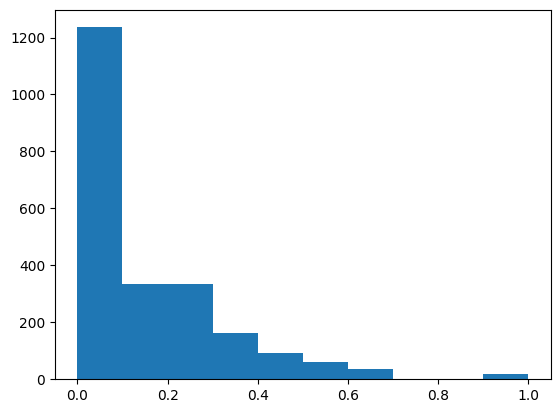

In [53]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import smogn

# Inspect Xgoal Probabilites Player sorted from the highest
directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xgoal"]["model_directory"]
output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xgoal"]["csv_output_filename"]
xgoal_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
xgoal_player_probs_df.sort_values(by="statistic_success_action_probs", ascending=False, inplace=True)

player_skills_column_included = ["acceleration", "aggression", "agility", "balance", "ball_control",
                                 "composure", "crossing", "curve", "dribbling", "finishing",
                                 "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
                                 "long_shots", "marking", "penalties", "positioning", "reactions",
                                 "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
                                 "standing_tackle", "strength", "vision", "volleys"]
xgoal_player_probs_df[player_skills_column_included] = xgoal_player_probs_df[player_skills_column_included] / 100

# min_samples = 62
# neighbors = NearestNeighbors(n_neighbors=min_samples)
# neighbors_fit = neighbors.fit(xgoal_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# distances, indices = neighbors_fit.kneighbors(xgoal_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.axis([2250, 2750, 0.4, 0.6])
# plt.plot(distances)

epsilon = 0.5
min_samples = 62
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(xgoal_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
labels = dbscan.labels_
outliers_data = xgoal_player_probs_df[labels == -1]
# plt.scatter(xgoal_player_probs_df["statistic_success_action_probs"], xgoal_player_probs_df["statistic_success_action_among_players"], c=labels)

# xgoal_player_probs_df = xgoal_player_probs_df[(xgoal_player_probs_df["statistic_success_action_probs"] <= 0.8) & (xgoal_player_probs_df["statistic_success_action_among_players"] <= 0.04)]
xgoal_player_probs_df = xgoal_player_probs_df[~xgoal_player_probs_df.index.isin(outliers_data.index)]
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
xgoal_player_probs_df[["statistic_success_action_probs"]] = scaler.fit_transform(xgoal_player_probs_df[["statistic_success_action_probs"]])
plt.hist(xgoal_player_probs_df["statistic_success_action_probs"])
plt.show()
# xgoal_player_probs_df[["full_name", "statistic_success_action_probs"]].sort_values(by="statistic_success_action_probs", ascending=False)[xgoal_player_probs_df["statistic_success_action_probs"] > 0.5][:60]

In [64]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Inspect Xdribble Probabilites Player sorted from the highest
directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xdribble"]["model_directory"]
output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xdribble"]["csv_output_filename"]
xdribble_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
xdribble_player_probs_df.sort_values(by="statistic_success_action_among_players", ascending=False, inplace=True)

player_skills_column_included = ["acceleration", "aggression", "agility", "balance", "ball_control",
                                 "composure", "crossing", "curve", "dribbling", "finishing",
                                 "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
                                 "long_shots", "marking", "penalties", "positioning", "reactions",
                                 "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
                                 "standing_tackle", "strength", "vision", "volleys"]
xdribble_player_probs_df[player_skills_column_included] = xdribble_player_probs_df[player_skills_column_included] / 100

# min_samples = 62
# neighbors = NearestNeighbors(n_neighbors=min_samples)
# neighbors_fit = neighbors.fit(xdribble_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# distances, indices = neighbors_fit.kneighbors(xdribble_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.axis([3000, 3600, 0.3, 0.6])
# plt.plot(distances)

epsilon = 0.5
min_samples = 62
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(xdribble_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
labels = dbscan.labels_
outliers_data = xdribble_player_probs_df[labels == -1]
# plt.scatter(xdribble_player_probs_df["statistic_success_action_probs"], xdribble_player_probs_df["statistic_success_action_among_players"])

xdribble_player_probs_df = xdribble_player_probs_df[~xdribble_player_probs_df.index.isin(outliers_data.index)]
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
xdribble_player_probs_df[["statistic_success_action_probs"]] = scaler.fit_transform(xdribble_player_probs_df[["statistic_success_action_probs"]])
# plt.hist(xdribble_player_probs_df["statistic_success_action_probs"])
# plt.show()
xdribble_player_probs_df[["full_name", "statistic_success_action_probs", "statistic_success_action_among_players", "statistic_success_total"]].sort_values(by="statistic_success_action_probs", ascending=False)

,full_name,statistic_success_action_probs,statistic_success_action_among_players,statistic_success_total
201,Rubén Blanco Veiga,1.00,0.000103,1.034465e-04
3218,Nabil Bahoui,1.00,0.000037,3.654358e-05
1561,Wout Weghorst,1.00,0.000034,3.373254e-05
2834,Alessandro Salvi,1.00,0.000034,3.373254e-05
3517,Leandro Chichizola,1.00,0.000034,3.429475e-05
...,...,...,...,...
982,Jamal Julian Campbell-Ryce,0.40,0.000002,1.799069e-06
3470,Ayoub El Kaabi,0.40,0.000004,3.598138e-06
3251,Jérémy Livolant,0.40,0.000002,1.799069e-06
1517,Dennis Praet,0.25,0.000003,2.529940e-06
